### Import dependencies

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import os
import matplotlib.pyplot as plt
import cProfile


### Setup

In [84]:
def path_to_symbols(base_dir="data"):
    """Return a list of symbols from a directory by removing the file extension `csv`."""
    file_list = os.listdir(base_dir)
    res =[]

    for file in file_list:
        file = file.split('.')
        if file[1] =="csv":
            res.append(file[0])
    return res
        
def symbol_to_path(symbol, base_dir= "data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df_container = pd.DataFrame(index=dates)
    # if 'SPY' not in symbols:  # add SPY for reference, if absent
    #     symbols.insert(0, 'SPY')
    if len(symbols) > 1:
        for symbol in symbols:
            df_temp = pd.read_csv("data/" + symbol + ".csv", index_col= "Date", parse_dates= True, usecols=['Date', 'Adj Close'], na_values="nan")
            df_temp = df_temp.rename(columns={'Adj Close':symbol})
            df_container = df_container.join(df_temp)
    else:
        df_temp = pd.read_csv("data/" + symbols[0] + ".csv", index_col= "Date", parse_dates= True, usecols=['Date', 'Adj Close'], na_values="nan")
        df_temp = df_temp.rename(columns={'Adj Close':symbols[0]})
        df_container = df_container.join(df_temp)

    df_container=df_container.dropna();

    return df_container

def plot_data(df:pd.DataFrame, title= "Stock prices"):
    """Plot stocks"""

    ax = df.plot(title=title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    return ax
    
def normalise_data(df:pd.DataFrame, frame_of_reference= 0):
    """Normalises the data based on the frame of reference"""
    return df/df.iloc[frame_of_reference]

def get_rolling_mean(df:pd.DataFrame, window = 20):
    return df.rolling(window).mean()

def get_rolling_std(df:pd.DataFrame, window = 20):
    return df.rolling(window).std()

def get_bollinger_bands(df:pd.DataFrame, window = 20, num_std = 2):
    """ Returns a tuple of Bollinger Bands® `(upper band, rolling mean , lower band)`"""

    rolling_mean = get_rolling_mean(df, window)
    std = get_rolling_std(df, window)
    upper_band = rolling_mean + num_std * std
    lower_band = rolling_mean - num_std * std

    return (upper_band, rolling_mean, lower_band)


def test_run():
    # Define a date range
    dates = pd.date_range('2010-01-01', '2010-12-30')

    # Choose stock symbols to read
    symbols = path_to_symbols()
    symbols = [symbols[2]]
    
    # Get stock data
    df = get_data(symbols, dates)
    # df = normalise_data(df)
    ax = plot_data(df)

    # compute rolling mean 
    window = 20
    bb = get_bollinger_bands(df, window)
    ub_df = bb[0]
    rm_df = bb[1]
    lb_df = bb[2]
    
    ub_df.plot(label="upper mean", ax=ax)
    rm_df.plot(label="rolling mean", ax=ax)
    lb_df.plot(label="lower mean", ax=ax)






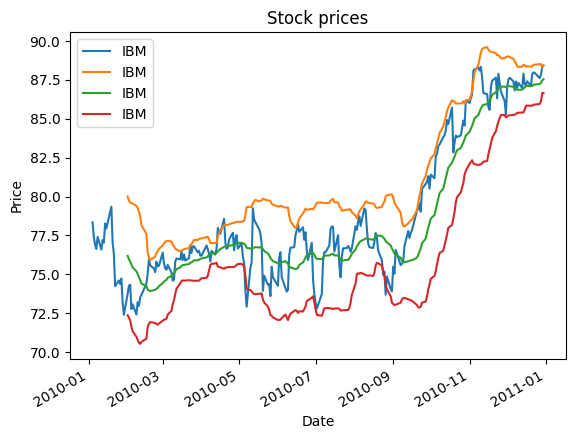

In [85]:
if __name__ == '__main__':
    test_run()
    print()

    # profile the performance of the code
    # cProfile.run("test_run()")


### Feature engineering